In [22]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import quantum as qm
import asymmetric as asym
import scipy.sparse.linalg as spla
import importlib
importlib.reload(asym)

# Naive

In [2]:
L = 5
_,x_list,y_list, z_list = qm.get_sigma_lists(L, half=False)
H = asym.dense_H(L)
Z0 = z_list[0]

In [3]:
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for T in range(tot):
    t = T/n
    U    = spla.expm(-1j*H*t)
    Uinv = spla.expm( 1j*H*t)
    Z0t = Uinv*Z0*U
    for i in range(L):
        OTOCs[i, T] = 1-np.real((Z0t*z_list[i]*Z0t*z_list[i]).diagonal().sum())/2**L

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


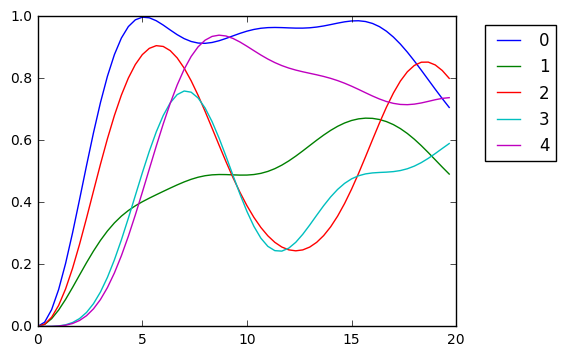

In [4]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Block Diagonal

In [5]:
def expm(a):
    if (a.shape[0]==1): return np.array([[np.exp(a[0,0])]])
    return spla.expm(a).A

In [6]:
Hlist  = asym.mat2list(H)
Zlists = [asym.mat2list(Z) for Z in z_list]
Z0list = Zlists[0]

In [14]:
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for T in range(tot):
    t = T/n
    Ulist    = [spla.expm(-1j*H*t) for H in Hlist]
    Ulistinv = [spla.expm( 1j*H*t) for H in Hlist]
    Z0tlist  = [Ui@Z0@U for (Ui, Z0, U) in zip(Ulistinv, Z0list, Ulist)]

    for i in range(L):
        corr = [Z0t@Zi@Z0t@Zi for (Z0t, Zi) in zip(Z0tlist, Zlists[i])]
        OTOCs[i, T] = 1-sum([c.diagonal().sum().real for c in corr])/2**L

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


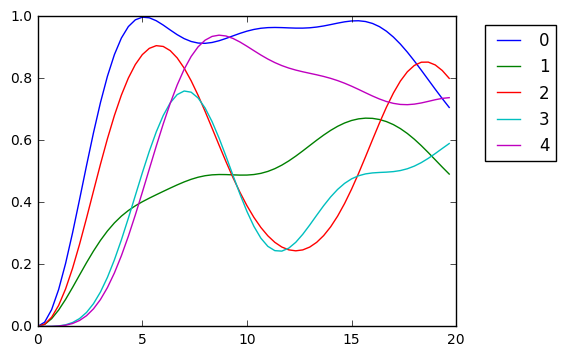

In [15]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Direct method, vectors

In [44]:
vec = qm.get_vec_Haar(2**L)
vecs = asym.arr2list(vec)

In [45]:
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for T in range(tot):
    t = T/n
    U    = spla.expm(-1j*H*t)
    Uinv = spla.expm( 1j*H*t)
    Z0t = Uinv*Z0*U
    for i in range(L):
        OTOCs[i, T] = 1-(vec.T.conj()@Z0t@z_list[i]@Z0t@z_list[i]@vec).real

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


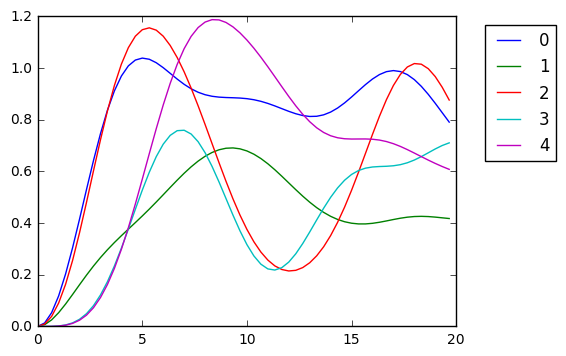

In [46]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Block diag vector

In [47]:
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for T in range(tot):
    t = T/n
    Ulist    = [spla.expm(-1j*H*t) for H in Hlist]
    Ulistinv = [spla.expm( 1j*H*t) for H in Hlist]
    Z0tlist  = [Ui@Z0@U for (Ui, Z0, U) in zip(Ulistinv, Z0list, Ulist)]

    for i in range(L):
        corr = [vec.conj().T@Z0t@Zi@Z0t@Zi@vec for (Z0t, Zi, vec) in zip(Z0tlist, Zlists[i], vecs)]
        OTOCs[i, T] = 1-sum([c.real for c in corr])/2**L

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


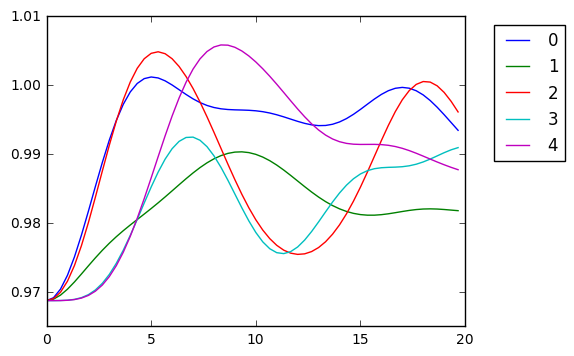

In [48]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# expm_mult, vectors

In [54]:
e = spla.expm_multiply
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for T in range(tot):
    t = T/n
    vbs  = [e(1j*H*t, Z0@e(-1j*H*t, vec)) for (H, Z0, vec) in zip(Hlist, Z0list, vecs)]

    for i in range(L):
        v1s = [e(1j*H*t, Z0@e(-1j*H*t, Zi@vec)) for (H, Z0, vec, Zi) in zip(Hlist, Z0list, vecs, Zlists[i])]
        v2s = [Zi@vb for (Zi, vb) in zip(Zlists[i], vbs)]
        OTOCs[i, T] = 1-sum([v2.conj().T@v1 for (v1, v2) in zip(v1s, v2s)]).real

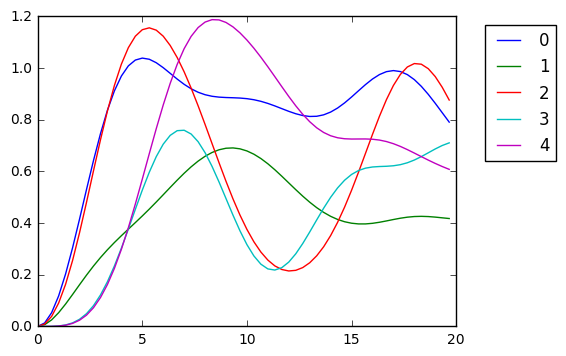

In [55]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

In [ ]:
list(map(np.square, [1,2,3,4]))

In [50]:
for i in range(3): print(i); print()

0

1

2



In [38]:
vec.T.conj()@Z0t@vec

(0.308366134081778-6.938893903907228e-17j)